### **NLP-BASED INTERVIEW SYSTEM**
#### This project develops a chatbot-like system that conducts data science interviews, evaluates responses, and provides feedback using NLP models.
#### ***Data Requirements***
##### - A dataset of high-quality interview questions and answers asked on data science interviews.
##### - Pre-trained NLP models for sentense embedding and evaluation.
##### - User responses for evaluation.
#### ***Goals***
##### - Implement an interview system that simulates a real world interview.
##### - Compare different models.
##### - Develop a scoring mechanism on how a user answered the asked interview question.

In [ ]:
#loading my libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import random
from scipy.stats import pearsonr
import string
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from sklearn.metrics import mean_squared_error
from sentence_transformers import SentenceTransformer, util
from transformers import DistilBertTokenizer, DistilBertModel
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

**Data Collection using web scraping**

In [ ]:
# Load local HTML
with open("C:/Users/Admin/Desktop/Data Scientist Interview Questions and Answers (All Levels) _ Himalayas.html", encoding='utf-8') as file:
    soup = BeautifulSoup(file, 'html.parser')

# Extract <p> and <ol> together (we’ll check for sequences)
elements = soup.find_all(['p', 'ol'])

qa_pairs = []
i = 0
while i < len(elements):
    el = elements[i]

    # Check for question
    if el.name == 'p' and el.find('strong') and "sample answer" not in el.text.lower():
        question = el.get_text(strip=True)

        # Look ahead for answer
        answer = ""
        if i + 1 < len(elements):
            next_el = elements[i + 1]
            
            # Case: <p> with <em> inside
            if next_el.name == 'p' and next_el.find('em'):
                answer += next_el.find('em').get_text(strip=True)

                # Check if another <ol> follows
                if i + 2 < len(elements) and elements[i + 2].name == 'ol':
                    bullets = elements[i + 2].find_all('li')
                    answer += "\n" + "\n".join([f"- {li.get_text(strip=True)}" for li in bullets])
                    i += 3
                else:
                    i += 2
            else:
                i += 1  # move forward normally if no answer found
        else:
            i += 1
        
        if question and answer:
            qa_pairs.append({'Question': question, 'Answer': answer})
    else:
        i += 1

# Save to CSV
df = pd.DataFrame(qa_pairs)

# Remove leading/trailing whitespace
df['Question'] = df['Question'].astype(str).str.strip()
df['Answer'] = df['Answer'].astype(str).str.strip()

# Remove any leftover HTML tags (if scraping missed any)
df['Question'] = df['Question'].apply(lambda x: re.sub(r'<.*?>', '', x))
df['Answer'] = df['Answer'].apply(lambda x: re.sub(r'<.*?>', '', x))


#  Normalize (remove excessive newlines, lowercasing)
df['Answer'] = df['Answer'].str.replace(r'\n+', '\n', regex=True)
df['Question'] = df['Question'].str.replace(r'\n+', ' ', regex=True)

# Remove starting and ending quotation marks
df['Answer'] = df['Answer'].str.strip('"“”')

# 'df' has a 'Question' column
pattern = r"^(Tell me about a|Describe a situation|Describe how ).*"

# Find rows where 'Question' starts with the given patterns
matching_rows = df[df['Question'].str.match(pattern)]

# Update the original DataFrame with 'Behavioral' as Type and 'Soft Skills' as Category
df.loc[df['Question'].str.match(pattern), 'Type'] = 'Behavioral'
df.loc[df['Question'].str.match(pattern), 'Category'] = 'Soft Skills'

df['Type'] = df['Type'].fillna('Technical')
df['Category'] = df['Category'].fillna('ML')

df = df[['Type', 'Category', 'Question', 'Answer']]
#LOADING THE DATAFRAME
df.head(5)


,Type,Category,Question,Answer
0,Technical,ML,Explain the difference between L1 and L2 regul...,"In my graduate research project at Stanford, I..."
1,Technical,ML,How would you detect and handle outliers in a ...,"During my internship at Tesla, I worked with s..."
2,Technical,ML,Design a simple recommendation system for an o...,I'd start with a collaborative filtering appro...
3,Behavioral,Soft Skills,Tell me about a time when you had to learn a n...,"During my internship at Facebook, I needed to ..."
4,Technical,ML,How would you design and evaluate a multi-arme...,"At Booking.com, I implemented an epsilon-greed..."


In [6]:
#check the response
url = 'https://raw.githubusercontent.com/youssefHosni/Data-Science-Interview-Questions-Answers/refs/heads/main/Deep%20Learning%20Questions%20%26%20Answers%20for%20Data%20Scientists.md'
response = requests.get(url)

#print the text of the response
md_text = response.text
md_text

#where the text is located
pattern = r'###\s*Q\d+:\s*(.*?)\s*###\s*\n+Answer:\s*(.*?)(?=\n### Q\d+:|$)'
qa_matches = re.findall(pattern, md_text, re.DOTALL)

# Step 3: Clean and save
qa_list = [{'Question': q.strip(), 'Answer': a.strip()} for q, a in qa_matches]
df1 = pd.DataFrame(qa_list)

# Remove leading/trailing whitespace
df1['Question'] = df1['Question'].astype(str).str.strip()
df1['Answer'] = df1['Answer'].astype(str).str.strip()

# Remove any leftover HTML tags (if scraping missed any)
df1['Question'] = df1['Question'].apply(lambda x: re.sub(r'<.*?>', '', x))
df1['Answer'] = df1['Answer'].apply(lambda x: re.sub(r'<.*?>', '', x))

# Normalize (remove excessive newlines, lowercasing)
df1['Answer'] = df1['Answer'].str.replace(r'\n+', '\n', regex=True)
df1['Question'] = df1['Question'].str.replace(r'\n+', ' ', regex=True)

# Function to clean markdown links, images, and plain URLs
def remove_links(text):
    # Remove image markdown: ![alt](url)
    text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
    # Remove markdown links: [text](url)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove standalone URLs: http:// or https://
    text = re.sub(r'http[s]?://\S+', '', text)
    # Clean up leftover blank lines
    text = re.sub(r'\n{2,}', '\n', text)
    return text.strip()

# Apply it to both question and answer columns
#df['question'] = df['question'].apply(remove_links)
df1['Answer'] = df1['Answer'].apply(remove_links)

#add in the colmn names
df1['Type'] = 'Technical'       # Empty column for topic
df1['Category'] = 'Deep Learning' # Empty column for category
df1 = df1[['Type', 'Category', 'Question', 'Answer']]

#load the dataframe
df1.head(5)


,Type,Category,Question,Answer
0,Technical,Deep Learning,What are autoencoders? Explain the different l...,Autoencoders are one of the deep learning type...
1,Technical,Deep Learning,What is an activation function and discuss the...,"In mathematical terms, the activation function..."
2,Technical,Deep Learning,You are using a deep neural network for a pred...,Hyperparameters are any parameter in the model...
3,Technical,Deep Learning,Can you explain the parameter sharing concept ...,Parameter sharing is the method of sharing wei...
4,Technical,Deep Learning,Describe the architecture of a typical Convolu...,"In a typical CNN architecture, a few convoluti..."


In [8]:
#combine the two dataframes with scaped data
df_combined = pd.concat([df, df1], ignore_index=True)
df_combined.head(5)


,Type,Category,Question,Answer
0,Technical,ML,Explain the difference between L1 and L2 regul...,"In my graduate research project at Stanford, I..."
1,Technical,ML,How would you detect and handle outliers in a ...,"During my internship at Tesla, I worked with s..."
2,Technical,ML,Design a simple recommendation system for an o...,I'd start with a collaborative filtering appro...
3,Behavioral,Soft Skills,Tell me about a time when you had to learn a n...,"During my internship at Facebook, I needed to ..."
4,Technical,ML,How would you design and evaluate a multi-arme...,"At Booking.com, I implemented an epsilon-greed..."


In [ ]:
#append the scraped data to the csv file
df_combined.to_csv('interview_qa_combined.csv', mode='a', header=False, index=False)


**Data Loading**

In [4]:
data = pd.read_csv('interview_qa_combined.csv', encoding='ISO-8859-1') #
data.head(5)

,Type,Category,Question,Answer
0,Technical,Statistics & Probability,Explain the central limit theorem and give exa...,The center limit theorem states that if any ra...
1,Technical,Statistics & Probability,Briefly explain the A/B testing and its applic...,A/B testing helps us to determine whether a ch...
2,Technical,Statistics & Probability,Describe briefly the hypothesis testing and p-...,In Layman's terms:- Hypothesis test is where y...
3,Technical,Statistics & Probability,Given a left-skewed distribution that has a me...,Left skewed distribution means the tail of the...
4,Technical,Statistics & Probability,What is the meaning of selection bias and how ...,Sampling bias is the phenomenon that occurs wh...


***Description***

The data to be used for this project is a collection of QA-pairs asked in a data science interview. So we'll have the questions asked in a data science interview then how they are answered. For easy identification of the questions we then categorize every question into categories (SQL, statistics & probability, Machine Learning, Python, soft skills).


**Data Cleaning**

In [3]:
#check for missing values
data.isna().sum()

Type        0
Category    0
Question    0
Answer      0
dtype: int64

In [4]:
#check for duplicates
data.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
621    False
622    False
623    False
624    False
625    False
Length: 626, dtype: bool

In [5]:
#removing whitespaces
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
data.head()

,Type,Category,Question,Answer
0,Technical,Statistics & Probability,Explain the central limit theorem and give exa...,The center limit theorem states that if any ra...
1,Technical,Statistics & Probability,Briefly explain the A/B testing and its applic...,A/B testing helps us to determine whether a ch...
2,Technical,Statistics & Probability,Describe briefly the hypothesis testing and p-...,In Layman's terms:- Hypothesis test is where y...
3,Technical,Statistics & Probability,Given a left-skewed distribution that has a me...,Left skewed distribution means the tail of the...
4,Technical,Statistics & Probability,What is the meaning of selection bias and how ...,Sampling bias is the phenomenon that occurs wh...


In [6]:
#clean text on the data
def clean_text(text):
    """
    Cleans text by fixing encoding issues, removing unwanted characters,
    and normalizing spaces.
    """
    # Fix encoding issues
    text = text.encode("utf-8").decode("utf-8", "ignore")  
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove emojis (optional, if you want no emoji left)
    #text = re.sub(r'[^\w\s,]', '', text)  

    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply Cleaning to Question and Answer Columns
data["Question"] = data["Question"].apply(clean_text)
data["Answer"] = data["Answer"].apply(clean_text)


In [10]:
data.to_csv('interview_qa_combined.csv', index=False, encoding='utf-8')

***NLP Modelling***

e5-base-v2

In [6]:
questions = data["Question"].tolist()
ideal_answers = data["Answer"].tolist()

# ----------- Load the Model -----------
print("Loading model...")
model = SentenceTransformer("intfloat/e5-base-v2")

def preprocess(text):
    return "query: " + text.strip()

# ----------- Select a Random Question -----------
random_idx = random.randint(0, len(data) - 1)
selected_question = questions[random_idx]
selected_ideal_answer = ideal_answers[random_idx]

print("\n=== Interview Question ===")
print(selected_question)

# ----------- Get User Answer -----------
user_input = input("\nYour Answer:\n")

# ----------- Embed Both Answers -----------
user_embedding = model.encode(preprocess(user_input), convert_to_tensor=True)
ideal_embedding = model.encode(preprocess(selected_ideal_answer), convert_to_tensor=True)

# ----------- Compute Similarity -----------
cos_score = util.cos_sim(user_embedding, ideal_embedding).item()
print(f"\nSimilarity Score: {cos_score:.4f}")

# ----------- Provide Feedback -----------
def get_feedback(score):
    if score >= 0.8:
        return "Excellent! Your answer closely matches the expected response."
    elif score >= 0.5:
        return "Partial match. You may need to elaborate or add more detail."
    else:
        return "Low match. Consider revisiting the key concepts in your response."

print(get_feedback(cos_score))


Loading model...

=== Interview Question ===
Explain the difference between GROUP BY and HAVING clauses in SQL.

Similarity Score: 0.8900
Excellent! Your answer closely matches the expected response.


DistilBERT

In [10]:
# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Function to get sentence embeddings from DistilBERT
def get_distilbert_embeddings(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    # Forward pass through DistilBERT model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the embeddings (we use the last hidden state, which corresponds to [CLS] token embeddings)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling of all token embeddings
    
    return embeddings

# Function to ask user a question and compare answer with actual answer
def ask_question_and_evaluate(data):
    # Select a random question from your dataset (or choose a specific question)
    question = data['Question'].sample().iloc[0]
    actual_answer = data[data['Question'] == question]['Answer'].iloc[0]
    print("\n=== Interview Question ===")
    print(question)
    #print("Actual Answer: ", actual_answer)  # For reference in evaluation, can be removed if not needed

    # Ask user for their answer
    user_answer = input("\nYour Answer:\n")

    # Compute embeddings for the question, user answer, and actual answer
    question_embedding = get_distilbert_embeddings(question)
    user_answer_embedding = get_distilbert_embeddings(user_answer)
    actual_answer_embedding = get_distilbert_embeddings(actual_answer)

    # Calculate cosine similarity between user's answer and actual answer embeddings
    similarity = cosine_similarity(user_answer_embedding, actual_answer_embedding)
    similarity_score = similarity[0][0]

    # Display similarity score
    print(f"\nSimilarity Score (User Answer vs Actual Answer): {similarity_score:.4f}")

    # Provide feedback based on similarity score
    if similarity_score > 0.8:
        print("Great! Your answer is very close to the correct answer.")
    elif similarity_score > 0.5:
        print("Your answer is somewhat relevant, but you might need to refine it further.")
    else:
        print("Your answer seems to be off from the correct answer. Try again with more details.")


# Ask the user a question and evaluate their answer
ask_question_and_evaluate(data)



=== Interview Question ===
What is the difference betweeen K nearest neighbors and K means

Similarity Score (User Answer vs Actual Answer): 0.8851
Great! Your answer is very close to the correct answer.


SentenceBERT

In [11]:
# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to get sentence embeddings from Sentence-BERT
def get_sentencebert_embeddings(text):
    return model.encode(text, convert_to_tensor=True)

# Function to ask user a question and compare answer with actual answer
def ask_question_and_evaluate(data):
    # Select a random question from your dataset (or choose a specific question)
    question = data['Question'].sample().iloc[0]
    actual_answer = data[data['Question'] == question]['Answer'].iloc[0]
    print("\n=== Interview Question ===")
    print(question)
    #print("Actual Answer: ", actual_answer)  # For reference, can be removed in the final version

    # Ask user for their answer
    user_answer = input("\nYour Answer:\n")

    # Compute embeddings for the user answer and actual answer
    user_answer_embedding = get_sentencebert_embeddings(user_answer)
    actual_answer_embedding = get_sentencebert_embeddings(actual_answer)

    # Calculate cosine similarity between user's answer and actual answer embeddings
    similarity = cosine_similarity([user_answer_embedding], [actual_answer_embedding])
    similarity_score = similarity[0][0]

    # Display similarity score
    print(f"\nSimilarity Score (User Answer vs Actual Answer): {similarity_score:.4f}")

    # Provide feedback based on similarity score
    if similarity_score > 0.8:
        print("Great! Your answer is very close to the correct answer.")
    elif similarity_score > 0.5:
        print("Your answer is somewhat relevant, but you might need to refine it further.")
    else:
        print("Your answer seems to be off from the correct answer. Try again with more details.")

# Ask the user a question and evaluate their answer
ask_question_and_evaluate(data)



=== Interview Question ===
What is the difference between online and batch learning?

Similarity Score (User Answer vs Actual Answer): 0.0253
Your answer seems to be off from the correct answer. Try again with more details.


***Evaluate these models***

In [ ]:
questions = data["Question"].tolist()
answers = data["Answer"].tolist()

e5base_model = SentenceTransformer("intfloat/e5-base-v2")

# Load DistilBERT model (needs tokenizer too)
from transformers import DistilBertModel, DistilBertTokenizer

distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load Sentence-BERT model (SBERT)
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


In [4]:
# DistilBERT embedding
def distilbert_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# E5 embedding (SentenceTransformer-based)
def e5_embedding(text, model):
    return model.encode("query: " + text, convert_to_tensor=True)

# Evaluate similarity across 3 models
def evaluate_similarity(user_answer, correct_answer):
    """Compute similarity using SBERT, E5-base, and DistilBERT."""
    
    # SBERT
    user_vector_sbert = sbert_model.encode(user_answer, convert_to_tensor=True)
    correct_vector_sbert = sbert_model.encode(correct_answer, convert_to_tensor=True)

    # E5-base
    user_vector_e5 = e5_embedding(user_answer, e5base_model)
    correct_vector_e5 = e5_embedding(correct_answer, e5base_model)

    # DistilBERT
    user_vector_distilbert = distilbert_embedding(user_answer, distilbert_tokenizer, distilbert_model)
    correct_vector_distilbert = distilbert_embedding(correct_answer, distilbert_tokenizer, distilbert_model)

    # Compute cosine similarities
    similarity_sbert = util.pytorch_cos_sim(user_vector_sbert, correct_vector_sbert).item()
    similarity_e5 = util.pytorch_cos_sim(user_vector_e5, correct_vector_e5).item()
    similarity_distilbert = cosine_similarity([user_vector_distilbert], [correct_vector_distilbert])[0][0]

    return {
        "sbert": similarity_sbert,
        "e5-base": similarity_e5,
        "distilbert": similarity_distilbert
    }


In [5]:
def ask_question():
    """Ask a question, get user input, and compare similarity across SBERT, E5-base, and DistilBERT."""
    question_index = random.randint(0, len(questions) - 1)
    question = questions[question_index]
    correct_answer = answers[question_index]

    print(f"\n=== Interview Question ===")
    print(question)
    user_response = input("\nYour Answer:\n")

    # Get similarity scores
    scores = evaluate_similarity(user_response, correct_answer)
    sim_sbert = scores["sbert"]
    sim_e5 = scores["e5-base"]
    sim_distilbert = scores["distilbert"]

    # Print results
    print(f"\nCorrect Answer: {correct_answer}")
    print(f"🔹 SBERT Similarity Score: {sim_sbert:.4f}")
    print(f"🔹 E5-base Similarity Score: {sim_e5:.4f}")
    print(f"🔹 DistilBERT Similarity Score: {sim_distilbert:.4f}")

    # Determine the best model
    best_score = max(sim_sbert, sim_e5, sim_distilbert)
    if best_score == sim_sbert:
        best_model = "SBERT"
    elif best_score == sim_e5:
        best_model = "E5-base"
    else:
        best_model = "DistilBERT"

    print(f"Best Model for this answer: {best_model}")

# Run the interview system
while True:
    ask_question()
    continue_response = input("\nDo you want another question? (yes/no): ").strip().lower()
    if continue_response != "yes":
        print("Exiting the interview. Good luck with your preparation!")
        break



=== Interview Question ===
Describe a situation where you had to make a difficult decision with limited data.

Correct Answer: In a supply chain optimization project, we lacked detailed data for certain regions. I decided to use historical trends as a proxy and built sensitivity analyses to assess the potential risks. This allowed the team to proceed with a robust strategy while monitoring for updates. The decision minimized delays and kept the project on schedule
🔹 SBERT Similarity Score: 0.0473
🔹 E5-base Similarity Score: 0.6752
🔹 DistilBERT Similarity Score: 0.5153
Best Model for this answer: E5-base

=== Interview Question ===
How Do You Assess the Statistical Significance of an Insight?

Correct Answer: You would perform hypothesis testing to determine statistical significance. First, you would state the null hypothesis and alternative hypothesis. Second, you would calculate the p-value, the probability of obtaining the observed results of a test assuming that the null hypothesis

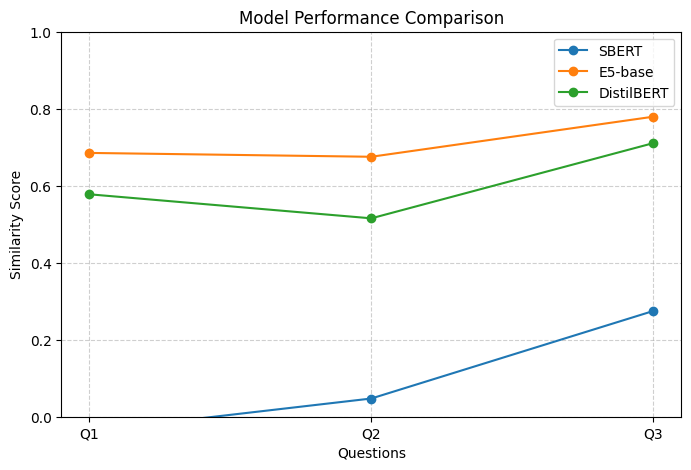

In [8]:
# Updated model names
models = ["SBERT", "E5-base", "DistilBERT"]

# Updated similarity scores for multiple questions
scores = [
   [-0.0375, 0.6852, 0.5777], 
    [0.0473, 0.6752, 0.5153],
    [0.2745, 0.7792, 0.7105]   
]

# Convert scores into a NumPy array
scores = np.array(scores)

# Set up x-axis labels (Q1, Q2, Q3, ...)
x_labels = [f"Q{i+1}" for i in range(scores.shape[0])]

# Set up figure and axis
plt.figure(figsize=(8, 5))

# Plot each model's scores
for i, model in enumerate(models):
    plt.plot(x_labels, scores[:, i], marker='o', linestyle='-', label=model)

# Labels and title
plt.xlabel("Questions")
plt.ylabel("Similarity Score")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)  # Similarity scores range from 0 to 1
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()


In [7]:
# Calculate average similarity for each model
average_scores = scores.mean(axis=0)

# Display average similarity per model
for model, avg_score in zip(models, average_scores):
    print(f"{model} Average Similarity Score: {avg_score:.4f}")


SBERT Average Similarity Score: 0.0948
E5-base Average Similarity Score: 0.7132
DistilBERT Average Similarity Score: 0.6012


Model Evaluations

In [5]:

# Load models once
e5_model = SentenceTransformer("intfloat/e5-base")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
distilbert_model = SentenceTransformer("distilbert-base-nli-stsb-mean-tokens")

# Sample data: list of dicts with question, user_answer, ideal_answer, ground truth score (0-10)
sample_data = sample_data = [
    {
        "question": "Why is mean square error a bad measure of model performance? What would you suggest instead?",
        "ideal_answer": "Mean Squared Error (MSE) gives a relatively high weight to large errors therefore, MSE tends to put too much emphasis on large deviations. A more robust alternative is MAE (mean absolute deviation).",
        "user_answer": "MSE squares errors and that might be bad if there are big errors. MAE could be better.",
        "score": 6  # partial answer, roughly 0.6 * 10
    },
    {
        "question": "Why is mean square error a bad measure of model performance? What would you suggest instead?",
        "ideal_answer": "Mean Squared Error (MSE) gives a relatively high weight to large errors therefore, MSE tends to put too much emphasis on large deviations. A more robust alternative is MAE (mean absolute deviation).",
        "user_answer": "MSE is used for errors. I think accuracy is better.",
        "score": 2  # poor answer, roughly 0.2 * 10
    },
    {
        "question": "Explain what a false positive and a false negative are. Why is it important to distinguish these from each other?",
        "ideal_answer": "A false positive is an incorrect identification of the presence of a condition when its absent.A false negative is an incorrect identification of the absence of a condition when its actually present.An example of when false negatives are more important than false positives is when screening for cancer. Its much worse to say that someone doesnt have cancer when they do, instead of saying that someone does and later realizing that they dont.This is a subjective argument, but false positives can be worse than false negatives from a psychological point of view. For example, a false positive for winning the lottery could be a worse outcome than a false negative because people normally dont expect to win the lottery anyway.",
        "user_answer": "False positive means detecting something that isn’t there, false negative means missing something that is there. Both are important for accuracy.",
        "score": 6  # partial answer
    },
    {
        "question": "Explain what a false positive and a false negative are. Why is it important to distinguish these from each other?",
        "ideal_answer": "A false positive is an incorrect identification of the presence of a condition when its absent.A false negative is an incorrect identification of the absence of a condition when its actually present.An example of when false negatives are more important than false positives is when screening for cancer. Its much worse to say that someone doesnt have cancer when they do, instead of saying that someone does and later realizing that they dont.This is a subjective argument, but false positives can be worse than false negatives from a psychological point of view. For example, a false positive for winning the lottery could be a worse outcome than a false negative because people normally dont expect to win the lottery anyway.",

        "user_answer": "False positive and false negative are just mistakes in predictions.",
        "score": 2  # poor answer
    }
]


def evaluate_with_e5(question, user_answer, ideal_answer):
    emb_user = e5_model.encode(f"query: {user_answer}", convert_to_tensor=True)
    emb_ideal = e5_model.encode(f"passage: {ideal_answer}", convert_to_tensor=True)
    similarity = util.cos_sim(emb_user, emb_ideal).item()
    score = int(round(similarity * 10))
    return score

def evaluate_with_sbert(question, user_answer, ideal_answer):
    emb_user = sbert_model.encode(user_answer, convert_to_tensor=True)
    emb_ideal = sbert_model.encode(ideal_answer, convert_to_tensor=True)
    similarity = util.cos_sim(emb_user, emb_ideal).item()
    score = int(round(similarity * 10))
    return score

def evaluate_with_distilbert(question, user_answer, ideal_answer):
    emb_user = distilbert_model.encode(user_answer, convert_to_tensor=True)
    emb_ideal = distilbert_model.encode(ideal_answer, convert_to_tensor=True)
    similarity = util.cos_sim(emb_user, emb_ideal).item()
    score = int(round(similarity * 10))
    return score

def compare_models(sample_data):
    from scipy.stats import pearsonr

    models = {
        "E5-base": evaluate_with_e5,
        "SBERT": evaluate_with_sbert,
        "DistilBERT": evaluate_with_distilbert
    }

    results = {}

    for model_name, eval_fn in models.items():
        predicted_scores = []
        ground_truth_scores = []
        for sample in sample_data:
            predicted_score = eval_fn(sample['question'], sample['user_answer'], sample['ideal_answer'])
            predicted_scores.append(predicted_score)
            ground_truth_scores.append(sample['score'])

        corr, _ = pearsonr(predicted_scores, ground_truth_scores)
        results[model_name] = corr

    print("Model evaluation comparison (Pearson correlation with ground truth scores):")
    for model_name, corr in results.items():
        print(f"{model_name}: {corr:.3f}")

if __name__ == "__main__":
    compare_models(sample_data)


Model evaluation comparison (Pearson correlation with ground truth scores):
E5-base: 1.000
SBERT: 1.000
DistilBERT: -0.302


In [6]:
# Load models once
e5_model = SentenceTransformer("intfloat/e5-base")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
distilbert_model = SentenceTransformer("distilbert-base-nli-stsb-mean-tokens")  # or another suitable DistilBERT model

# Example dataset: list of (question, ideal_answer, user_answer)
data = sample_data = [
    {
        "question": "Why is mean square error a bad measure of model performance? What would you suggest instead?",
        "ideal_answer": "Mean Squared Error (MSE) gives a relatively high weight to large errors therefore, MSE tends to put too much emphasis on large deviations. A more robust alternative is MAE (mean absolute deviation).",
        "user_answer": "MSE squares errors and that might be bad if there are big errors. MAE could be better.",
        #"score": 6  # partial answer, roughly 0.6 * 10
    },
    {
        "question": "Why is mean square error a bad measure of model performance? What would you suggest instead?",
        "ideal_answer": "Mean Squared Error (MSE) gives a relatively high weight to large errors therefore, MSE tends to put too much emphasis on large deviations. A more robust alternative is MAE (mean absolute deviation).",
        "user_answer": "MSE is used for errors. I think accuracy is better.",
        #"score": 2  # poor answer, roughly 0.2 * 10
    },
    {
        "question": "Explain what a false positive and a false negative are. Why is it important to distinguish these from each other?",
        "ideal_answer": "A false positive is an incorrect identification of the presence of a condition when its absent.A false negative is an incorrect identification of the absence of a condition when its actually present.An example of when false negatives are more important than false positives is when screening for cancer. Its much worse to say that someone doesnt have cancer when they do, instead of saying that someone does and later realizing that they dont.This is a subjective argument, but false positives can be worse than false negatives from a psychological point of view. For example, a false positive for winning the lottery could be a worse outcome than a false negative because people normally dont expect to win the lottery anyway.",
        "user_answer": "False positive means detecting something that isn’t there, false negative means missing something that is there. Both are important for accuracy.",
        #"score": 6  # partial answer
    },
    {
        "question": "Explain what a false positive and a false negative are. Why is it important to distinguish these from each other?",
        "ideal_answer": "A false positive is an incorrect identification of the presence of a condition when its absent.A false negative is an incorrect identification of the absence of a condition when its actually present.An example of when false negatives are more important than false positives is when screening for cancer. Its much worse to say that someone doesnt have cancer when they do, instead of saying that someone does and later realizing that they dont.This is a subjective argument, but false positives can be worse than false negatives from a psychological point of view. For example, a false positive for winning the lottery could be a worse outcome than a false negative because people normally dont expect to win the lottery anyway.",

        "user_answer": "False positive and false negative are just mistakes in predictions.",
        #"score": 2  # poor answer
    }
]


ground_truth_scores = [10] * len(data)  # Perfect scores for ideal answers

e5_scores = []
sbert_scores = []
distilbert_scores = []

for question, ideal_answer, user_answer in data:
    # Encode answers and compute cosine similarity for E5
    emb_user_e5 = e5_model.encode(user_answer, convert_to_tensor=True)
    emb_ideal_e5 = e5_model.encode(ideal_answer, convert_to_tensor=True)
    sim_e5 = util.cos_sim(emb_user_e5, emb_ideal_e5).item()
    score_e5 = sim_e5 * 10
    e5_scores.append(score_e5)

    # SBERT similarity
    emb_user_sbert = sbert_model.encode(user_answer, convert_to_tensor=True)
    emb_ideal_sbert = sbert_model.encode(ideal_answer, convert_to_tensor=True)
    sim_sbert = util.cos_sim(emb_user_sbert, emb_ideal_sbert).item()
    score_sbert = sim_sbert * 10
    sbert_scores.append(score_sbert)

    # DistilBERT similarity
    emb_user_distil = distilbert_model.encode(user_answer, convert_to_tensor=True)
    emb_ideal_distil = distilbert_model.encode(ideal_answer, convert_to_tensor=True)
    sim_distil = util.cos_sim(emb_user_distil, emb_ideal_distil).item()
    score_distil = sim_distil * 10
    distilbert_scores.append(score_distil)

# Calculate RMSE (manual sqrt for compatibility)
rmse_e5 = np.sqrt(mean_squared_error(ground_truth_scores, e5_scores))
rmse_sbert = np.sqrt(mean_squared_error(ground_truth_scores, sbert_scores))
rmse_distil = np.sqrt(mean_squared_error(ground_truth_scores, distilbert_scores))



print(f"E5-base RMSE: {rmse_e5:.3f}")
print(f"SBERT RMSE: {rmse_sbert:.3f}")
print(f"DistilBERT RMSE: {rmse_distil:.3f}")


E5-base RMSE: 0.855
SBERT RMSE: 5.717
DistilBERT RMSE: 3.981
